#Classification

In this tutorial, we will be working with **supervised learning** - learning a model from data with known outcomes. **Classification** is a form of supervised learning where the outcome is a discrete *class*. For example, if we wanted to build a spam detector for our email inbox, messages may be classified as *email* or *spam*. If we were building a model to recognize handwritten digits (for example to read checks at an ATM), the outcome would be one of 10 possible classes, one for each digit (0-9).

Similarly, in a hospital, we may want to predict whether an Intensive Care Unit (ICU) patient will live or die. The [2012 PhysioNet/Computing in Cardiology challenge](http://physionet.org/challenge/2012/) provides a dataset of ICU stays longer than 48 hours and whether or not the patient died in the hospital. We can use this dataset to train a classifier that, based on the patient record, predicts if the patient will survive.

## Loading the Data

The raw dataset can be found on the challenge website linked above. However, for this tutorial, we did some preprocessing for you so that we can focus on the machine learning part. If you want to know more about what we did, see the [Data Preparation](#Data-Preparation) section at the bottom of the tutorial.

We provide a [training set](https://raw.githubusercontent.com/lydiagu/ml-tutorial/master/physionet/train-a.csv) and a [test set](https://raw.githubusercontent.com/lydiagu/ml-tutorial/master/physionet/test-a.csv). Recall that a training set is used for training a model and a test set is used for evaluating the model performance on unseen data. The files are stored as .csv, with a header labeling the columns. Let's load the training set by using the `requests` library to download the file. `requests` is an easy-to-use library for making HTTP requests.

In [1]:
import requests
response = requests.get('https://raw.githubusercontent.com/lydiagu/ml-tutorial/master/physionet/train-a.csv')
raw_data = response.content  # Read the .csv content from the response.

Python's [`csv`](https://docs.python.org/2/library/csv.html) library has a `reader` object that will parse the .csv file. You can create a `reader` object by calling `csv.reader()` and passing in a file as the argument. Because `csv.reader()` expects a file-like object as the argument, we wrap the downloaded data string in a [`StringIO`](https://docs.python.org/2/library/stringio.html) object, which allows you to read the string like a file.

In [2]:
import csv
import StringIO

f = StringIO.StringIO(raw_data)
reader = csv.reader(f)

# The first row in the file is the header of column names.
csv_header = reader.next()

# Iterate over remaining rows to get the data.
data = []
for row in reader:
    row = [float(r) for r in row]  # Convert all values to floats.
    data.append(row)

What's in our dataset? Let's print the .csv header to see the column names.

In [3]:
print csv_header

['ALP_diff', 'ALP_first', 'ALP_last', 'ALP_max', 'ALP_mean', 'ALP_min', 'ALT_diff', 'ALT_first', 'ALT_last', 'ALT_max', 'ALT_mean', 'ALT_min', 'AST_diff', 'AST_first', 'AST_last', 'AST_max', 'AST_mean', 'AST_min', 'Age', 'Albumin_diff', 'Albumin_first', 'Albumin_last', 'Albumin_max', 'Albumin_mean', 'Albumin_min', 'BUN_diff', 'BUN_first', 'BUN_last', 'BUN_max', 'BUN_mean', 'BUN_min', 'Bilirubin_diff', 'Bilirubin_first', 'Bilirubin_last', 'Bilirubin_max', 'Bilirubin_mean', 'Bilirubin_min', 'Cholesterol_diff', 'Cholesterol_first', 'Cholesterol_last', 'Cholesterol_max', 'Cholesterol_mean', 'Cholesterol_min', 'Creatinine_diff', 'Creatinine_first', 'Creatinine_last', 'Creatinine_max', 'Creatinine_mean', 'Creatinine_min', 'DiasABP_diff', 'DiasABP_first', 'DiasABP_last', 'DiasABP_max', 'DiasABP_mean', 'DiasABP_min', 'FiO2_diff', 'FiO2_first', 'FiO2_last', 'FiO2_max', 'FiO2_mean', 'FiO2_min', 'GCS_diff', 'GCS_first', 'GCS_last', 'GCS_max', 'GCS_mean', 'GCS_min', 'Gender', 'Glucose_diff', 'Gluc

Whoa, that's a lot of columns! Let's take a closer look. We refer to the input data as **features** and the output data (in-hospital death) as **labels**. The dataset has two kinds of features:
  - **static features** that are measured at the begining of the ICU stay and don't change over time: age, gender, height, ICUType
  - **time-varying features** that are measured and recorded at a specific point in time, and may be measured 0 or more times during the ICU stay: Weight, Glucose, etc.

To have a uniform way of representing 0 or more records for each time-varying feature, we computed the min, max, mean, first value, last value and difference between first and last values for each. That's why there are so many features! The medical measurements themselves are explained in more detail on the [Physionet website](http://physionet.org/challenge/2012/).

For time-varying features that were not recorded for a patient, the computed statistics have value -1. Similarly, static features that were not recorded are also represented by -1. -1 is a useful number for representing a missing value because all of the valid, non-missing values are nonnegative. 

The last field in the .csv file is the label: `In-hospital_death`. 1 means the patient died in the hospital. 0 means the patient survived.

Let's separate the features from the label and store them in [`numpy`](http://docs.scipy.org/doc/numpy/user/index.html) arrays. `numpy` is a Python library useful for scientific computing, and it defines array objects for storing scientific data, as well as many mathematical functions. [`scikit-learn`](http://scikit-learn.org/stable/), the Python machine learning library we'll be using in this tutorial, is designed to work well with data in `numpy` arrays.

In [4]:
import numpy

# Python Tip:
# In Python lists, an index of -1 represents the last value in the list. Python
# list ranges do not include the interval end. So a range of [0:-1] does not
# include the last value in the list.

X = numpy.array([f[0:-1] for f in data])  # Features represented by `X`.
y = numpy.array([f[-1] for f in data])  # Labels represented by `y`.

## Understanding the Data

Now that we've loaded the data and looked at what features are in our dataset, let's dig into the data. A good place to start is by measuring the proportion of positive outcomes. The proportion of positive outcomes is just the mean of the labels, since we conveniently represented the labels as either 0 or 1. Since we put our data into numpy arrays, we can take advantage of some [very useful methods on arrays](http://docs.scipy.org/doc/numpy/reference/arrays.ndarray.html).

In [5]:
print y.mean()

0.145625


The proportion is fairly low (as would hopefully be expected with modern medicine!).

Let's use a visualization library called [matplotlib](http://matplotlib.org/api/) to visualize some of the features. First, we'll look at one feature and plot the histogram to get an idea of the distribution of the values. `matplotlib` has a specific function [`hist()`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.hist) for computing and plotting histograms.

The following line enables IPython Notebook's matplotlib mode:

In [6]:
%matplotlib inline

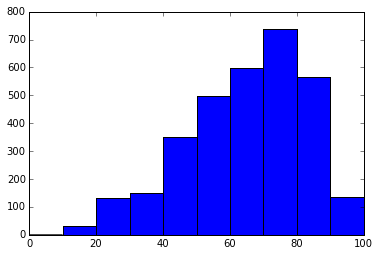

In [7]:
import matplotlib.pyplot as plt

# Exercise 1: You can replace 'Age' with another feature name to plot a
# different feature.
age_idx = csv_header.index('Age')  # Get the index of the 'Age' column.
ages = X[:, age_idx]  # Extract the 'Age' column from the array of features.

# hist() takes an array of numbers and computes and plots the histogram.
# You can pass in keyword arguments like bins (the number of bins) and
# range (the range of values the bins cover).
n, bins, patches = plt.hist(ages, bins=10, range=(0,100))
plt.show()

As would be expected, the histogram peaks at an older age (75).

___
**Exercise 1:** Can you plot the histogram of another feature? For example, Weight_mean or GCS_mean. Hint: if you remove the `bins` and `range` keyword arguments to `plt.hist`, it automatically finds a reasonable set of bins for your data.
___

## Building a Model

`Scikit-learn` uses a common API for all of their machine learning models, which makes it really easy to try different models. Let's start with a simple [logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

**NOTE:** A logistic regression model is *not* used for regression -- it is used for *classification*. Confusing! It's naming comes from the fact that it uses a linear model (similar to linear regression) to map the inputs to outputs. However, it then passes the output through a function (the logistic sigmoid function) which scales the value to be between 0 and 1, and increases the steepness of the curve around the midpoint - the image below plots the logistic function. We can then pick a threshold value (for example, 0.5), below which the point is classified as one class, and above which it is classified as the other class. This is how the model is used for classification.

<img src="http://upload.wikimedia.org/wikipedia/commons/8/88/Logistic-curve.svg" width="30%" height="30%"></img>

First, we'll split the dataset into a train and test set, with 80% used for training.

In [8]:
TRAIN_SIZE = int(0.8 * len(X))
print '# in training set:', TRAIN_SIZE
X_train = X[:TRAIN_SIZE]
y_train = y[:TRAIN_SIZE]
X_test = X[TRAIN_SIZE:]
y_test = y[TRAIN_SIZE:]

# in training set: 2560


Because logistic regression is based on a linear model, it won't handle missing values represented by -1 very well. Scikit-learn has an [`Imputer`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) class that provides basic strategies for filling in, or *imputing*, missing values. Let's use the strategy of using the mean of the known values to replace the missing values.

In [9]:
from sklearn.preprocessing import Imputer
# Initialize the Imputer class with stragegy 'mean'.
imp = Imputer(missing_values=-1, strategy='mean')
# fit_transform() fits the imputer on the data and applies the imputing
# transform.
X_train_imputed = imp.fit_transform(X_train)

Linear models are also sensitive to different ranges for input features. For example, if one input feature has a range of -1 to 1 and another has a range of 0 to 100, the feature with the larger range will disproportionately influence the model. To combat this, we scale all the features to **zero mean and unit variance**, using scikit-learn's [`StandardScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) class.

Note: We filled in missing values before scaling, otherwise the number used to represent missing values would distort the scaling.

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()  # Initialize the scaler class.
# fit_transform() fits the scaler to the data and applies the transform.
X_train_scaled = scaler.fit_transform(X_train_imputed)

Ok, now we're ready to train the model. Scikit-learn's models all have a `fit()` function to fit the model to the training data and a `predict()` function to predict outcomes on new input data.

In [11]:
from sklearn import linear_model
model = linear_model.LogisticRegression()
# Train the model with the training data.
model.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

## Evaluating a Model
Now that we have a model, how do we tell how good it is? Since we have labelled outcomes to compare predictions to, we can quantitatively measure how well the model is doing. This is where we use the test set. Because we only used the training set to develop the model, we can use the test set to see how well the model works on unseen data. With classification, each outcome is either predicted correctly or not, so the measure of success is binary.

Models in scikit-learn usually have a `score()` method, which takes in a set of features and their labels. For logistic regression, this method returns the **accuracy** of the model on the input data. Accuracy is the number of outcomes correctly predicted divided by the total number of outcomes.

In [12]:
X_test_scaled = scaler.transform(imp.transform(X_test))
print model.score(X_test_scaled, y_test)
# Exercise 2: call model.score() on the training set.

0.85625


___
**Exercise 2:** How does the accuracy on the test set compare to the accuracy on the training set? Can you compute the accuracy on the training set? Hint: `X_train_scaled` are the input features for the training set and `y_train` are the labels.
___

Remember from before that the proportion of positive outcomes is fairly low (~14%). This means that accuracy is not necessarily a very useful metric of model performance. A model which predicts survival for each patient (the negative outcome) would still be ~86% accurate!

Thankfully, there are other metrics for model performance. Before we go into these metrics, let's define a few terms. In binary classification, there is a **positive** outcome and a **negative** outcome. Typically, the positive outcome is the case you'd like to detect (ex. detecting a malignant tumor, or spam email), and the negative outcome is the more normal, generally expected outcome (ex. not a tumor, or is email). In our example, the positive outcome is an in-hospital death. The prediction results can be one of the following:
* **true positive**: a correctly predicted positive outcome
* ** false positive**: a negative outcome incorrectly predicted as positive
* ** true negative**: a correctly predicted negative outcome
* ** false negative**: a positive outcome incorrectly predicted as negative

Let's now apply these terms to other metrics for model performance:
* **recall**, also known as **sensitivity** or **true positive rate**: of the positive outcomes (in-hospital death), how many did we predict correctly. This is the number of true positives over the total number of positives.
* **precision**, also known as **positive predictivity**: of the outcomes predicted as positive, what fraction was correct. This is the number of true positives over the total number of predicted positives.

One method of visualizing these metrics is to plot the precision-recall curve. Recall from the logistic regression description above that we set a *threshold* for classifying an outcome as positive or negative. Most models output a prediction *probability* for each data point so you can manually adjust the threshold. For example, if we set the threshold to 0, all outcomes will be predicted as positive. This gives 100% recall and a precision of 14.5% (the proportion of true positives).

In the code below, we use scikit-learn's [`precision_recall_curve()`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) to compute the precision recall curve. The function adjusts the threshold and computes the precision/recall at each threshold value. This curve allows you to pick the right precision/recall for your application. For example, in a cancer screening test, you may want very high recall, but are ok with low precision because patients will receive follow-up tests.

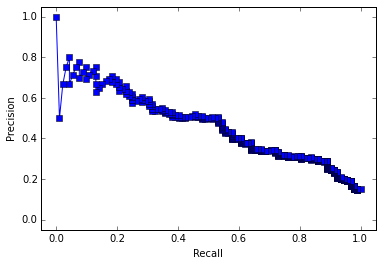

In [13]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# predict_proba() returns probability estimates for each class as an
# N x 2 array, where N is the number of data points and 2 is the number
# of classes. The negative outcome is the first column, and the positive
# outcome is the second column.
predicted_probs = model.predict_proba(X_test_scaled)

# We use the probability estimate for the positive outcome in
# precision_recall_curve().
precision, recall, thresholds = precision_recall_curve(
    y_test, predicted_probs[:,1])

# Plot precision and recall.
plt.plot(recall, precision, 's-', lw=1)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

___
**Exercise 3:** If we want to predict at least 50% of all in-hospital deaths (recall), what is the minimum percentage of predicted deaths that will be wrong (precision)? What if we wanted a recall of 80%?
___
**Exercise 4:** If I had 1000 patients and set the threshold for 80% recall, how many in-hospital deaths will be incorrectly predicted (false positive)?
___

One measure of model performance (and the method used in the Physionet challenge) is the minimum of precision and recall. One would pick the point in the curve that maximizes this minimum.

In [14]:
# Zip takes multiple lists [a1, a2, a3] and [b1, b2, b3] and returns a new list
# with elements at the same index combined: [(a1, b1), (a2, b2), (a3, b3)]
both = zip(precision, recall)
print 'Max min of Precision/Recall', max([min(r) for r in both])

Max min of Precision/Recall 0.505376344086


___
**Exercise 5:** Try using a [Random Forest Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) instead of a logistic regression model. Start with the default parameter settings. A random forest model averages the result of many decision trees trained on random subsets of the data. How do the results compare? Hint: replace `linear_model.LogisticRegression` in the code box at the end of the "Building a Model" section with `ensemble.RandomForestClassifier`. Don't forget to import the `ensemble` module! Click the link to see the sci-kit learn documentation.

What happens if you increase the number of estimators (the number of trees in the forest)? Hint: set `n_estimators` when creating a `RandomForestClassifier` object.
___

## Model Selection

How do we decide whether to use the logistic regression model or the random forest classifier? In addition, models themselves often have a few parameters than need to be tuned, for example, the number of decision trees in the random forest. How do we make these decisions?

We can try all of the various possibilities and evaluate the solution on the test set. The model that gives the best results is the winner. However, we don't want to use our test set for this selection process because we then won't have any unseen data to make a final evaluation. We need a *third* partition to our dataset set to evaluate the model, referred to as the "validation set". Instead of creating a fixed third partition as the validation set, we can use the method of **cross-validation.** This uses different splits of the training set for training and evaluation.

Scikit-learn has a library of utilities for cross-validation and performance evaluation in the `sklearn.cross-validation` module. It has several classes which automatically generate different splits of the training set. We will be using the `StratifiedKFold` iterator, which splits the data into *n* folds. *n - 1* folds are used for training, and the *nth* fold is used for test. A stratified K-fold maintains approximately the same percentage of each outcome class in each fold as in the complete set.

Let's use the stratified K-fold method to create train/test splits and use the average of the results of the K folds to evaluate our model choice.

In [15]:
from sklearn.cross_validation import StratifiedKFold
skf = StratifiedKFold(y, 5)  # 5 = number of folds

max_precision_recall_values = []
for train, test in skf:
    # `train` and `test` are lists of the indices for the train and test
    # sets.
    X_train = X[train]
    y_train = y[train]
    X_test = X[test]
    y_test = y[test]

    # Here, we repeat all the preprocessing and model training that we
    # went through in the code blocks above.
    imp = Imputer(missing_values=-1, strategy='mean')
    X_train_imputed = imp.fit_transform(X_train)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    model = linear_model.LogisticRegression()
    model.fit(X_train_scaled, y_train)
    X_test_scaled = scaler.transform(imp.transform(X_test))
    predicted_probs = model.predict_proba(X_test_scaled)
    precision, recall, thresholds = precision_recall_curve(y_test, predicted_probs[:,1])
    both = zip(precision, recall)
    max_precision_recall = max([min(r) for r in both])
    print 'Max min of Precision/Recall', max([min(r) for r in both])
    max_precision_recall_values.append(max_precision_recall)

print 'Mean value over 5 folds:', numpy.mean(max_precision_recall_values)

Max min of Precision/Recall 0.342105263158
Max min of Precision/Recall 0.45
Max min of Precision/Recall 0.408602150538
Max min of Precision/Recall 0.494623655914
Max min of Precision/Recall 0.505376344086
Mean value over 5 folds: 0.440141482739


___

**Exercise 6:** Use Stratified K-fold to measure the performance of the random forest classifier.
___

## Evaluating on the Test Set

So far, we haven't touched the test set. This was intentional, so that you have a pristine dataset to test your final model on after we went through all the topics above. Try loading the data on your own from [https://raw.githubusercontent.com/lydiagu/ml-tutorial/master/physionet/test-a.csv](https://raw.githubusercontent.com/lydiagu/ml-tutorial/master/physionet/test-a.csv) and evaluating your model!

## Data Preparation

Raw data is not a nice csv. How did we preprocess the data?

We only used the training set from the challenge website because that's the only labelled dataset available to the public. We further split the challenge training set into a train and test set for this tutorial (`train-a.csv` and `test-a.csv`).

The featurization code can be found on [github](https://github.secureserver.net/lgu/techfest-ml-tutorial/blob/master/physionet/create_featurized_datasets.py). It both featurizes the dataset and splits it into train and test sets. Each patient record file is read and stored as a dictionary of metric name to list of measurements. Then for each metric name, we compute the min, max, mean, first value, last value and difference between first and last values. If no measurements were recorded for that metric, all of those features would be -1. 
